这篇文章通过 手写数字识别 来讨论分类问题

In [1]:
# 准备工作
#准备工作

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# 基本包的导入
import numpy as np
import os

# 画图相关
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# 忽略警告
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='internal')

# 图片存储目录
PROJECT_ROOT_DIR = '../'
CHAPTER_ID = 'classifiction'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("保存图片:", fig_id)
    
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### MNIST 数据集


作为机器学习的hello world 项目，每当有新的机器学习算法时，该数据集就会被用于评估该模型的性能。

In [2]:
from sklearn.datasets import fetch_mldata 
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

如上方法通过 函数从网络上下载数据集，默认保存在 ` $HOME/scikit_learn_data.`目录。  
通过sklearn 下载的数据都有以下结构：  
1. DESCR：数据集的描述
2. data： 数据集的数据，每行是一个实例， 每列是一个特征。
3. target: 数据集的标签，即需要预测的值。

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

如上，包含该70000张图片，每张图片有28 * 28 个像素，共计784个特征。   
可以对每张图片进行可视化。

保存图片: some_digit_plot


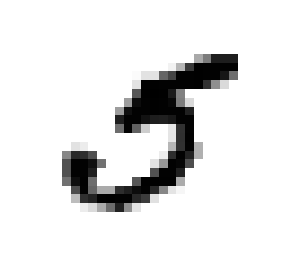

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
save_fig("some_digit_plot")
plt.show()

In [7]:
y[36000] #可以看到图片和标签都为5.

5.0

In [8]:
# 定义一个函数来查看图片
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

保存图片: more_digits_plot


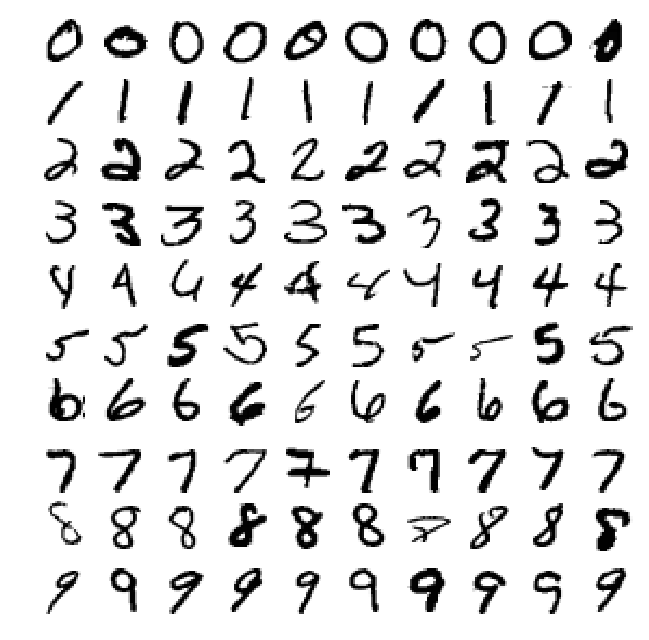

In [9]:
# 查看更多图片， 10 * 10
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row: (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9, 9))
example_images = np.r_[X[:12000:600], X[13000:30600:600],  X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [10]:
# 切分测试集用于后续预测
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
# 由于该训练集对于顺序没有要求，不像股票数据或者天气数据。不是一般性，将其随机打乱
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y[shuffle_index]

### 训练一个二元分类器

从一个简单的为开始识别手写数字。首先判断一个实例是否为5.  
目标向量：

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5

array([False, False, False, ..., False, False, False])

现在可以找一个分类器对其训练。从 随机梯度下降分类器开始，优点在神将网络中也有提到，能快速处理大的数据集, 非常适合在线学习。

In [13]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])  # 可以看到对图片 5 预测正确， 返回true。

array([ True])

### 评估性能

评估分类模型的精确度要比回归模型复杂的多。下面使用交叉验证来对该模型进行评估：

In [14]:
# 交叉验证， 为了保证随机抽样，可以自定义交叉验证方法，进行随机抽样。
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9478 , 0.9661 , 0.95695])

In [15]:
# 进行随机抽样，交叉验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    
    X_test_folds = X_train[test_index]
    y_test_folds = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))
    

0.96525
0.946
0.9578


In [16]:
# 看起来精确度还不错，下面定义一个最简单的分类器：
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) #永远返回0， 即预测等于5失败。

In [17]:
# 猜一下精确度
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9072 , 0.9104 , 0.91135])

上述结果也有90的精确度，因为对于本次训练来说，不是5的比率在90%， 因此无论怎么训练，精确度最低都在90%。  
这说明了为什么精度通常不是用于分类器的首选性能度量， 特别是在某些类出现的比较频繁时。

### Confusion Matrix : 混淆矩阵

In [18]:
# 使用cross_val_predict
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred.shape

(60000,)

该函数与cross_val_score()类似，不过结果不是交叉验证的分数，而是每个测试fold的预测值。
这意味着可以得到一个 “清晰” 的预测值， 即该值所对应的实例不参与训练。

In [19]:
# 得到混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53404,  1175],
       [ 1035,  4386]])

得到如上混淆矩阵：每行代表真实值，每列代表预测值。
比如第一行表示 为非5(nagative class)的图像数， 其中52849张( true nagative) 预测分类正确；1730张(false nagative) 图片预测失败。
第二行表示 为5(positive class) 的图像数，843预测失败，4587张测成功，共计60000张图片。

最理想的模型计算得到的混淆只包括 true positives 和 true negatives 两项。


In [20]:
confusion_matrix(y_train_5, y_train_5) #假设y_train_5就是预测值。

array([[54579,     0],
       [    0,  5421]])

混淆矩阵包含太多可用的信息。可以使用以下方法衡量分类器的准确度。  
precision = TP / (TP + FP)

这里存在一个问题。假设训练集中只有单一的正确值(5的图片只有一张)， 那么预测正确的话，精确度就是100%。
但是模型一般会忽略正确值而预测错误，因此这种精确度 不是非常有用。  
因此经常需要结合 recall 这种衡量方法， 也叫做 sensitivisy 和 true positive rate。  
计算方法为  recall = TP / (TP + FN), 通常表示预测正确的占比。  

![%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-23%2001.18.28.png](attachment:%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-23%2001.18.28.png)

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 4587 / (4587 + 1730)

0.7887070670742672

In [22]:
recall_score(y_train_5, y_train_pred) # 4587 / (4587 + 834)

0.8090758162700609

以上结果相比之前的度量方法有不同。  
比如只有84%的精确度，并且只识别出了68%的正确图片5.

recall 越高，说明模型对正样本的识别能力越强，precision 体现了模型对负样本的区分能力，precision越高，说明模型对负样本的区分能力越强。  
F1-score 是两者的综合。F1-score 越高，说明分类模型越稳健。

更方便的，可以将精确度和召回率 组合为一个度量方法， 称为F1 分数，可以理解为两个度量的调和平均值。  
F1可以用于不同分类器的比较。  
此计算方法会加重 较小值的权重，因此在精确度和recall 都很高且接近的时候，才可以较高的F1分数。
![%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-23%2001.38.09.png](attachment:%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-23%2001.38.09.png)

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7987616099071208

F1评分倾向于具有相似精度和召回率的分类器。但是某个情况比较在意精确度，某些情况比较在意recall。  
但是不可能增加精确度的同时减少recall， 这称为 `precision/recall tradeoff`

#### 精确度/召回率 权衡

可以这样理解：对于二分类问题，当精确度超过某一阈值， 可认为属于该类，否则就是相反类。
如下图所示比较清晰明显。
![%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-24%2023.18.50.png](attachment:%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-24%2023.18.50.png)

可以看到不同的阈值对precision/recall的影响。很明显，低阈值会增加召回率，降低精确度。

In [24]:
y_scores = sgd_clf.decision_function([some_digit])

y_scores

array([196299.0887045])

这里`decision_function()`返回每个实例对应的值， 可以设定阈值预测是不是图片5.
如下：

In [25]:
# 使用阈值来决定不同precision/recall
# 
threshold = 0 # 较小阈值
y_some_digit_pred = (y_scores > threshold)


In [26]:
y_some_digit_pred  # 与阈值比较

array([ True])

In [27]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

问题就变成怎么选择一个合适的阈值：

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [29]:
y_scores

array([ -32157.86377015, -523112.94314864, -416206.34162326, ...,
       -264549.48061965, -386687.84946726,  -62311.26052902])

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [31]:
def plot_precision_recall_vs_threshold(precisions, recall, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=15)
    plt.ylim([0, 1])

保存图片: precision_recall_vs_thresold_plot


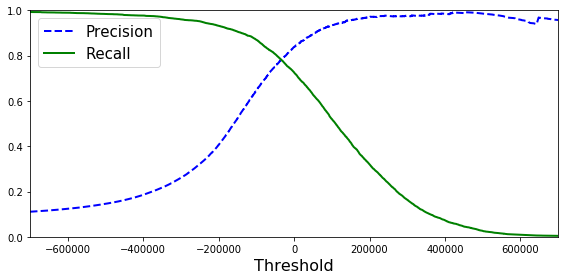

In [32]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_thresold_plot")
plt.show()

从上图 可以看出，随着阈值的调整，精度度和召回率也在变化，目标就是找到一个最合适的值。

In [33]:
(y_train_pred == (y_scores > 0)).all()

False

In [34]:
(y_train_pred == (y_scores > 70000)).all()

False

In [35]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.9154243119266054

In [36]:
recall_score(y_train_5, y_train_pred_90)

0.5890057185021214

In [37]:
def plot_precision_vs_recall(precisions, recalls):
    
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

保存图片: precision_vs_recall_plot


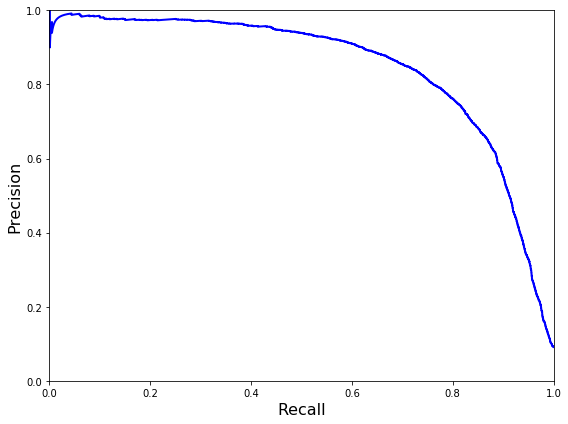

In [38]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

PR曲线：可以看到precision开始大幅下降到召回率为80%处。此时就可以选择一个平衡方案，拨入召回率在60%左右处的地方。 

### ROC 曲线
针对二分类问题的另一种工具。

In [39]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

保存图片: roc_curve_plot


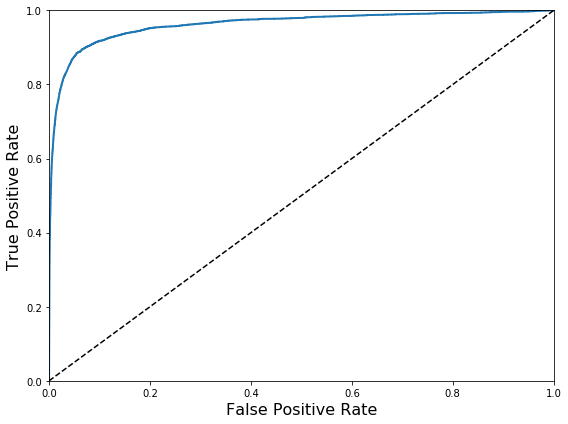

In [41]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

解释一下这个图：ROC为受试者工作特征曲线，也是二分类问题的一个工具。
其非常近似于precision/recall 曲线。不用在于该曲线是true positive rate(召回率)相对于false positive rate的变化。后者是错样本被分类正确的比例，等于(1 - true negative rate, 负样本被分类为负样本的比例)。
此图也是一个平衡。召回率越高， 分类器产生的FPR就越高。虚线代表一个随机的分类器，好的分类器应往左上角尽量远离该虚线。

另一种方式是测量曲线下的面积(AUC)。一个好的分类器表现为ROC的 AUC = 1。随机分类器则为0.5.
sklearn中有方法计算RUC， 如下：

In [42]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)  # 接近1

0.962243374355393

In [43]:
# 使用随机森林分类器
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,  method="predict_proba")

In [44]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

保存图片: roc_curve_comparison_plot


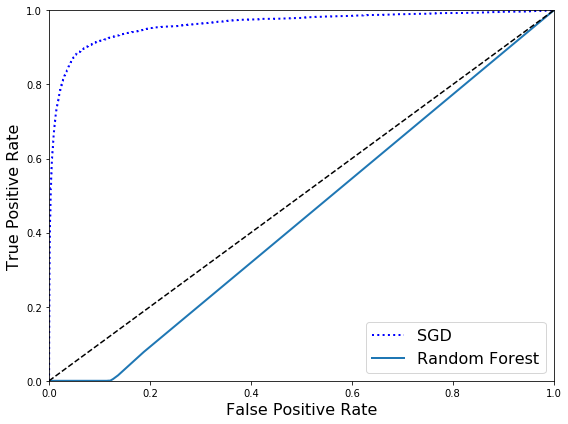

In [45]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

上图有错误，RF的效果应该更好，后续研究改正。

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

0.4402554832700905

In [47]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9843232501655995

In [48]:
recall_score(y_train_5, y_train_pred_forest)

0.8223574986164914

### 多分类

上面讨论的是二分类问题。但是比如RF， NB(naive Bayes)都可以处理多分分类问题。而不像线性分类， SVM等只能处理二分类，当然通过一定的策略也可以多分类。

比如有两种方法：像手写数字识别，可以分别计算每中图片得到的分数，去最高值，这种叫做one-versus-all(OvA).
另一种就是 两两比较分类，one-versusone(OvO),共需计算n*(n-1)次。结果就是看哪个分类赢的次数多。

In [49]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) 

array([5.])

In [50]:
some_digit_score = sgd_clf.decision_function([some_digit])
some_digit_score # 计算不同分类的分数，最大值即为目标分类

array([[-189894.13822166, -362292.17586644, -403503.49315649,
         -93796.7202532 , -424057.73089707,   14176.63616212,
        -616892.89582452, -480673.21976264, -698840.6781573 ,
        -658431.03097224]])

In [51]:
np.argmax(some_digit_score)

5

In [52]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

sklearn中提供了相应的方法OvO， OvA。

In [53]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [54]:
len(ovo_clf.estimators_)

45

In [55]:
# 使用随机森林分类器预测， 方法比较简单
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [56]:
forest_clf.predict_proba([some_digit]) # 每个分类的可能性，最大值为目标分类。

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

根据结果可以看到，还是20%的可能性会分类成图片8.

In [57]:
# 使用交叉验证
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8614777 , 0.85339267, 0.86497975])

In [58]:
# 进行特征缩放后精确度明显提高
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90706859, 0.91084554, 0.91128669])

### 错误分析
假设现在有一个还可以的模型，想办法怎么提高性能。  
一种方式是分析出错的类型

In [59]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx # 混淆矩阵

array([[5734,    2,   23,    8,   10,   47,   45,    9,   40,    5],
       [   2, 6489,   42,   27,    6,   46,    7,   12,  101,   10],
       [  57,   34, 5348,   94,   76,   27,   92,   58,  155,   17],
       [  54,   37,  137, 5324,    4,  252,   37,   58,  139,   89],
       [  25,   22,   36,   10, 5363,   10,   54,   27,   79,  216],
       [  73,   44,   35,  176,   70, 4622,  101,   29,  181,   90],
       [  34,   23,   45,    2,   36,   97, 5631,    6,   44,    0],
       [  29,   22,   72,   32,   60,   11,   10, 5782,   18,  229],
       [  52,  154,   71,  149,   11,  162,   58,   26, 5031,  137],
       [  47,   26,   23,   92,  161,   43,    3,  200,   84, 5270]])

In [60]:
def plot_confusion_matirx(matrix):
    """
    color and colorbar
    """
    fig = plt.figure(figsize=(8,8))
    ax=fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

保存图片: confusion_matrix_plot


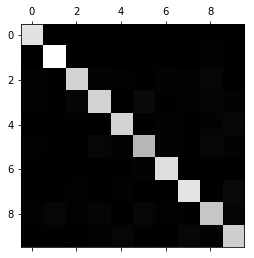

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

此混淆矩阵看起来很不错， 因为大部分图片都在对角线上，意味着分类正确了。  
图片5看起来要暗一些， 意味着数据集中有较少的图片被分类成图片5， 不像其他分类那样表现的好(更亮).  

现在把注意力放在错误上。如下过程计算相应分类，就可以比较错误率而不是错误分类的数量(因为不同分类图片的总数不一样，所以难以比较)

In [62]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.68090495e-01, 3.37666723e-04, 3.88316731e-03, 1.35066689e-03,
        1.68833361e-03, 7.93516799e-03, 7.59750127e-03, 1.51950025e-03,
        6.75333446e-03, 8.44166807e-04],
       [2.96647879e-04, 9.62474043e-01, 6.22960546e-03, 4.00474637e-03,
        8.89943637e-04, 6.82290122e-03, 1.03826758e-03, 1.77988727e-03,
        1.49807179e-02, 1.48323939e-03],
       [9.56696878e-03, 5.70661296e-03, 8.97616650e-01, 1.57771064e-02,
        1.27559584e-02, 4.53172205e-03, 1.54414233e-02, 9.73481034e-03,
        2.60154414e-02, 2.85330648e-03],
       [8.80769858e-03, 6.03490458e-03, 2.23454575e-02, 8.68373838e-01,
        6.52422117e-04, 4.11025934e-02, 6.03490458e-03, 9.46012070e-03,
        2.26716686e-02, 1.45163921e-02],
       [4.27935638e-03, 3.76583362e-03, 6.16227319e-03, 1.71174255e-03,
        9.18007532e-01, 1.71174255e-03, 9.24340979e-03, 4.62170490e-03,
        1.35227662e-02, 3.69736392e-02],
       [1.34661502e-02, 8.11658366e-03, 6.45637336e-03, 3.24663346e-02,
   

保存图片: confusion_matrix_errors_plot


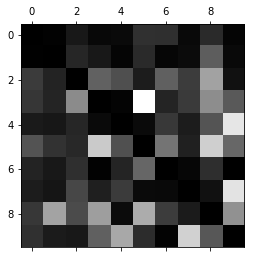

In [63]:
np.fill_diagonal(norm_conf_mx, 0)  #设置对角元素
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()


现在可以清晰的看到分类器分类错误了。  
行表示实际分类， 列表示预测分类。可以明显看到8，9列比较亮，说明很多图片错误分类成8， 9.
8, 9行也相对较亮，说明8， 9图片也会与其他图片混合，分类错误。

相对的，有些行比较暗，比如1， 说明大部分1分类正确， 少部分分类为8.
分析混淆举证通常会得到更深的见解去提高分类结果。

保存图片: error_analysis_digits_plot


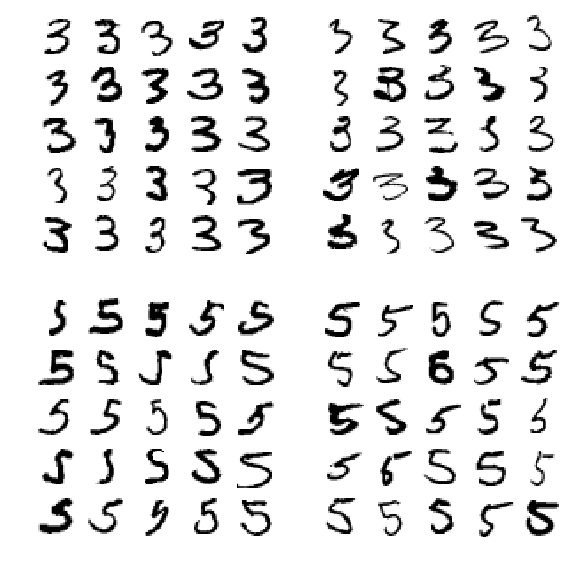

In [64]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

### 多标签分类

In [65]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [66]:
knn_clf.predict([some_digit]) #可以看到对于多标签分类，也是正确的。

array([[False,  True]])

In [67]:
# 交叉验证计算f1分数，可能花费数小时，不在此计算。
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
# f1_score(y_multilabel, y_train_knn_pred, average="macro") #

### 多输出分类

In [68]:
noise = np.random.randint(0, 100, (len(X_train), 784))# 产生0-100的噪声
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


保存图片: noisy_digit_example_plot


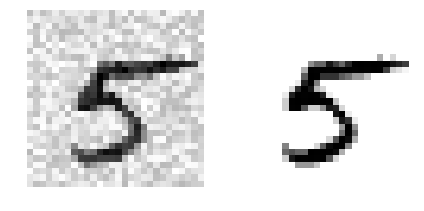

In [69]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

保存图片: cleaned_digit_example_plot


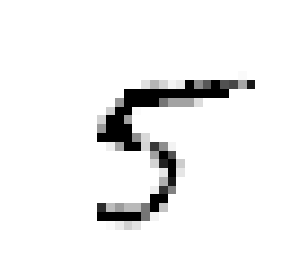

In [70]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

### 课后习题

In [71]:
# 随机分类器
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=5, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

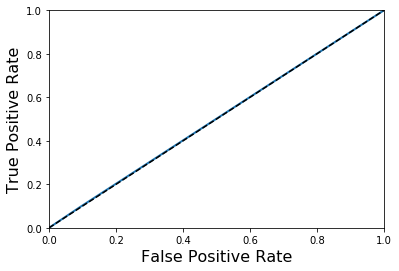

In [72]:
fprr, tprr, thresholder = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr) #证明上述ROC曲线在随机分类的情况下，接近0.5.

KNN 分类器

In [75]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights="distance", n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [78]:
# 去预测
y_knn_pred = knn_clf.predict(X_test)

In [77]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

可以看到knn分类得到的精确度还是蛮高的。

### 课后习题

In [84]:
### 使用网格搜索对knn分类进行超参数调节，得到更好的精确度
from sklearn.model_selection import GridSearchCV
param_grid = [{"weights": ["uniform", "distance"], "n_neighbors": [3, 4, 5]}]

# 用全部60000条数据会很耗时，这里选取2000条数据
X_train_small = X_train[:2000]
y_train_small = y_train[:2000]
knn_clr = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train_small, y_train_small)  # 运行会很耗时

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=distance .................................
[CV] n_neighbors=3, weights=distance .................................
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=uniform, score=0.8916256157635468, total=   1.4s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=uniform, score=0.8507462686567164, total=   1.4s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=uniform, score=0.8421052631578947, total=   1

[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:   28.2s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   28.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

训练完成，可以看到输出的详细的日志。下面看一下跑出的结果：

In [85]:
# 最佳参数
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [88]:
grid_search.best_score_ # 减少了数据，否则精确度应该在97左右。

0.8945

### 数据扩充
在对图片的在任意方向移动一个像素，得到4张图片并添加到训练集训练。最后得到的分数会比现在的高。
如下

In [91]:
from scipy.ndimage.interpolation import shift
def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [92]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

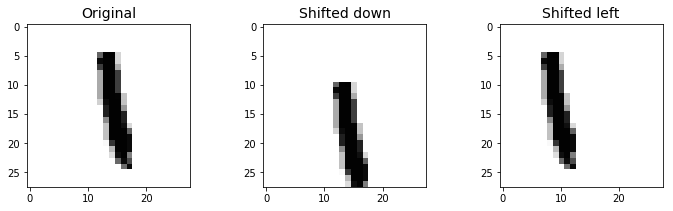

In [93]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [96]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)


shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented[:3000], y_train_augmented[:3000])
# X_train_augmented.shape # (300000, 784),过大，训练一部分

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')

In [97]:
# 下面进行预测评分
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9173

因为采用一部分数据集的原因。
若是全部数据参与训练，结果分数应该是有所boost 提高的。

#### 泰坦尼克生还人

In [103]:
import os
TITANIC_PATH = os.path.join("../datasets", "titanic")

import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [104]:
# 先大概看一下数据
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


包含以下特征：
* Survived：1表示生还，0表示为生还
* Pcalss：乘客类别
* Name, sex, age: 个人属性
* SibSp: 兄弟姐妹个数
* Parch：父母个数
* TIcker： 船票ID
* Fare： 票价已付
* Cabin：乘客房间号
* Embarked： 登船位置

In [105]:
# 看一下数据缺失的程度
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


结果所示， age， Cabin，和Embarked有不同的程度的缺失(小于891)
其中Cabin中77%数据都是空的，可以删除忽略。
age中19%是空的，需要决定怎么去处理， 可以使用年龄中位数去fill。

Name 和ticket 特征可能有一定的价值，但是将其转为模型可用的数据会比较麻烦，因此选择忽略。

In [106]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


观察结果：只有38%的人生还，接近40%。因此可以用精确度去衡量。
Fare票的平均值为32， 看起来并不是很贵。
平均年龄都少于30岁。

In [107]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [113]:
# 下面看一下所有的类别特征
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [114]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [115]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked 有三个类别，表示从不同的地方登船。
使用之前介绍的 CategoricalEncoder 来对其ont hot编码处理：

In [116]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, no need to try to
# understand every line.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

开始编写数据转换管道 pipeline

In [133]:
from sklearn.base import BaseEstimator, TransformerMixin

#A class 选择数值列 或者 类别列
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [134]:
# 编写处理数值列的pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])), 
     ("imputer", Imputer(strategy="median")), 
])

In [135]:
# 使用pipeline 训练填充数据
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [141]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


同时也需要估计类别特征列的空值数据，而imputer没有此功能。

In [136]:
# Inspired from stackoverflow.com/questions/25239958

# 使用最多出现的那个类别填充
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent)

In [145]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense')),
])

In [146]:
cat_pipeline.fit_transform(train_data) #编码成功

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

最后，将两个pipeline合并在一起

In [149]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion( transformer_list= [
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

非常好，现在有一个能处理数据集的转换器，能同时装换数值和类别特征， 向机器学习的其他算法一样使用。

In [150]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [152]:
pd.DataFrame(X_train).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
0     891 non-null float64
1     891 non-null float64
2     891 non-null float64
3     891 non-null float64
4     891 non-null float64
5     891 non-null float64
6     891 non-null float64
7     891 non-null float64
8     891 non-null float64
9     891 non-null float64
10    891 non-null float64
11    891 non-null float64
dtypes: float64(12)
memory usage: 83.6 KB


可以看到将缺失值填充，并且对数据进行了转换。